In [1]:
from __future__ import (division, print_function)

In [135]:
%autoreload 2
%matplotlib inline

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import h5py
#import seaborn as sns
#sns.set_style('white')

In [5]:
import statsmodels as sm

In [6]:
#from seaborn.distributions \
#    import _statsmodels_bivariate_kde as bivariate_KDE

In [197]:
import sys
sys.path.append("../")
import extract_catalog as ec
import plot_gal_prop as plotg
import get_DM_centroids as getDM
import get_KDE 

In [8]:
partDMfile = "../../data/Illustris-1_" + \
    "00135_APillepich_KarenNG_ParticleData_Group_PartType1.h5"

data_f = h5py.File("../../data/Illustris-1_fof_subhalo" +
                   "_myCompleteHaloCatalog_00135.hdf5")

In [9]:
partDM = h5py.File(partDMfile)

In [10]:
no = 7
size=1e3

In [11]:
part_halos = h5py.File("../../data/DM_particles_clst_loc.h5")
haloEndIx = part_halos["loc"][...]

In [12]:
haloEndIx[5] - haloEndIx[4]

30285624

# the first halo id is 1 ..... different than other index scheme

to correct for consistency, we add the starting index of 0 

In [28]:
haloEndIx = [0] + list(haloEndIx)

In [102]:
partDM.keys()

[u'PartType1_Coordinates', u'PartType1_HaloID', u'PartType1_Masses']

In [105]:
partDM["PartType1_HaloID"][haloEndIx[clstNo]: haloEndIx[clstNo+1]] == 8

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [84]:
crds = \
    partDM["PartType1_Coordinates"][:, haloEndIx[clstNo]: haloEndIx[clstNo+1]]

In [125]:
75 / 106.5

0.704225352112676

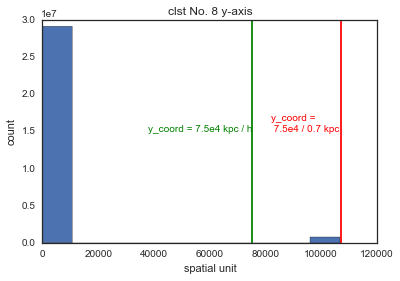

In [132]:
_ = plt.hist(crds[1])
plt.axvline(7.5e4 / 0.7, color='r')
plt.text(8.2e4, 1.5e7, "y_coord = \n 7.5e4 / 0.7 kpc", color='r')
plt.axvline(7.5e4, color='g')
plt.text(3.8e4, 1.5e7, "y_coord = 7.5e4 kpc / h", color='g')
plt.title("clst No. 8 y-axis")
plt.xlabel("spatial unit")
plt.ylabel("count")


In [142]:
clstNo = 7
coord_dict = ec.get_DM_particles([clstNo], partDM, 
                                 dataPath="../../data/")

In [221]:
fhat = getDM.make_histogram_with_2kpc_resolution(coord_dict[7])

In [228]:
get_KDE.find_peaks_from_py_diff(fhat)
get_KDE.get_density_weights(fhat)
peaks_mask = fhat["peaks_dens"] > 0.3

In [256]:
fhat.keys()

['peaks_colIx',
 'peaks_rowIx',
 'peaks_ycoords',
 'peaks_dens',
 'estimate',
 'eval_points',
 'peaks_xcoords']

have a background count threshold on the density

In [260]:
fhat["peaks_xcoords"]

array([ -2.59724805e+03,   1.21630859e+00,  -5.81982422e+03, ...,
        -4.71962793e+03,  -4.71962793e+03,  -8.13023730e+03], dtype=float32)

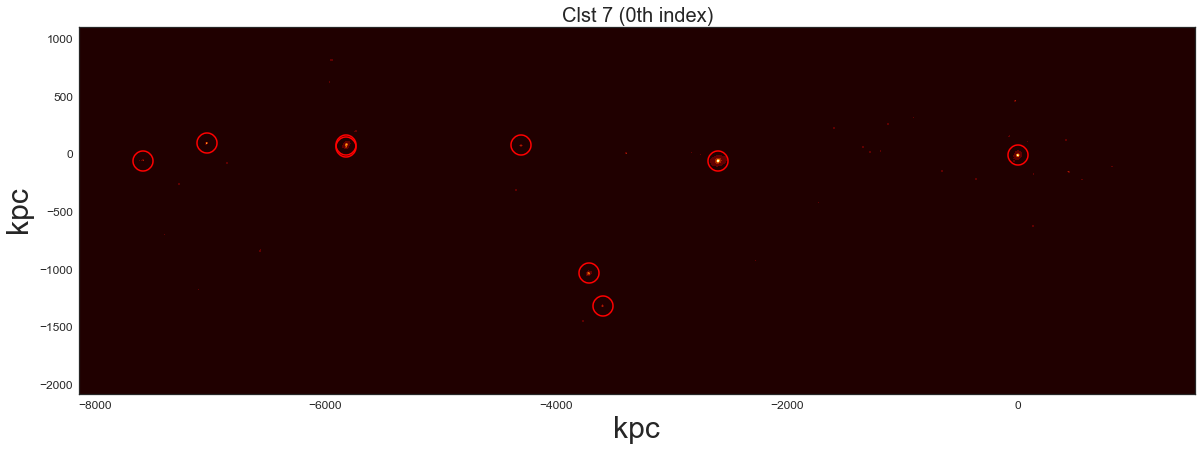

In [270]:
plt.figure(figsize=(20, 20))
plt.axes().set_aspect('equal')
plt.title("Clst 7 (0th index)", size=20)
plt.xlabel("kpc", size=30)
plt.ylabel("kpc", size=30)
plt.tick_params(labelsize='large')

plt.contourf(fhat["eval_points"][0], fhat["eval_points"][1],
            fhat["estimate"].transpose(), cmap=plt.cm.afmhot)

for i in np.arange(0, len(fhat["peaks_xcoords"]), 1)[peaks_mask]:
    plt.plot(fhat["peaks_xcoords"][i], fhat["peaks_ycoords"][i],
             "ro", fillstyle="none", mew=1.5, ms=20)

#plt.colorbar()

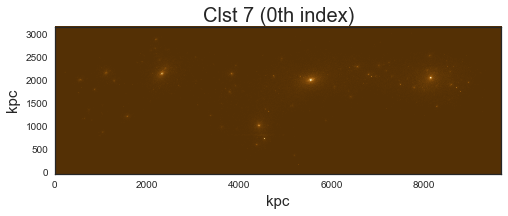

In [164]:

fig = plt.figure(figsize=(8, 8))
plt.axes().set_aspect('equal')
counts, xedges, yedges, image = \
    plt.hist2d(coord_dict[clstNo]["coords"][:, 0],
               coord_dict[clstNo]["coords"][:, 1], 
               bins=bins[:2], cmap=plt.cm.BrBG)
plt.title("Clst 7 (0th index)", size=20)
plt.xlabel("kpc", size=15)
plt.ylabel("kpc", size=15)


In [218]:
edges = [xedges, yedges]

In [219]:
xedges

array([  0.00000000e+00,   2.00035763e+00,   4.00071526e+00, ...,
         9.67372949e+03,   9.67572949e+03,   9.67773047e+03], dtype=float32)

In [220]:
edges[0][1:] - edges[0][:-1]

array([ 2.00035763,  2.00035763,  2.00035763, ...,  2.        ,
        2.        ,  2.00097656], dtype=float32)

In [172]:
bins

array([ 4838,  1590, 53249])

array([  0.00000000e+00,   2.00035763e+00,   4.00071526e+00, ...,
         9.67372949e+03,   9.67572949e+03,   9.67773047e+03], dtype=float32)

In [166]:
counts.shape

(4838, 1590)

In [167]:
bins

[4838, 1590, 53249]

In [16]:
def get_dens_and_grid(x, y, bw='normal_reference', 
                      gridsize=100, cut=4, 
                      clip=[-np.inf, np.inf], n_jobs=10):
    from seaborn.distributions \
    import _kde_support 
    import statsmodels.nonparametric.kernel_density as KDE
    KDEMultivariate = KDE.KDEMultivariate
    
    kde = KDEMultivariate(np.array([x, y]),
                          var_type='cc', bw=bw)
    kde.n_jobs = n_jobs
    
    x_support = _kde_support(x, kde.bw[0], gridsize, cut, clip)
    y_support = _kde_support(y, kde.bw[1], gridsize, cut, clip)
    xx, yy = np.meshgrid(x_support, y_support)
      
    z = kde.pdf([xx.ravel(), yy.ravel()]).reshape(xx.shape)
    return xx, yy, z
    

In [ ]:

axis1_range = \
    np.max(wrapped_coords[:, 0]) - np.min(wrapped_coords[:, 0])

In [ ]:
xbin_width

In [ ]:
plt.figure(figsize=(16, 16))
plt.imshow(counts.transpose(), cmap=plt.cm.BrBG,
           origin='lower')
plt.title(partDM['PartType1_HaloID'][haloEndIx[no-1]],
          fontsize=30)

```
get_dens_and_grid(wrapped_coords[:, 0], wrapped_coords[:, 1])
```